# **Load Data**

## **Import Libraries**

In [1]:
# Standard library imports
import os
from os.path import join
from collections import Counter

# Third-party library imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat  # Thư viện đọc file .mat
from scipy.signal import butter, filtfilt, iirnotch, stft
from scipy.stats import f_oneway, ttest_ind

import mne
from mne.preprocessing import ICA

Only extract signals from channels 4-17 (the main EEG channels) for analysis

| Channel_names | Position      |
|---------------|---------------|
| AF3           | Front (Anterior)    |
| AF4           | Front (Anterior)    |
| F7            | Lateral Front      |
| F8            | Lateral Front      |
| F3            | Left Front         |
| F4            | Right Front     |
| FC5           | Mid-Front     |
| FC6           | Mid-Front     |
| T7            | Left Temporal         |
| T8            | Right Temporal         |
| O1            | Occipital (Back of Head)  |
| O2            | Occipital (Back of Head)  |
| P7            | Left Parietal |
| P8            | Right Parietal |

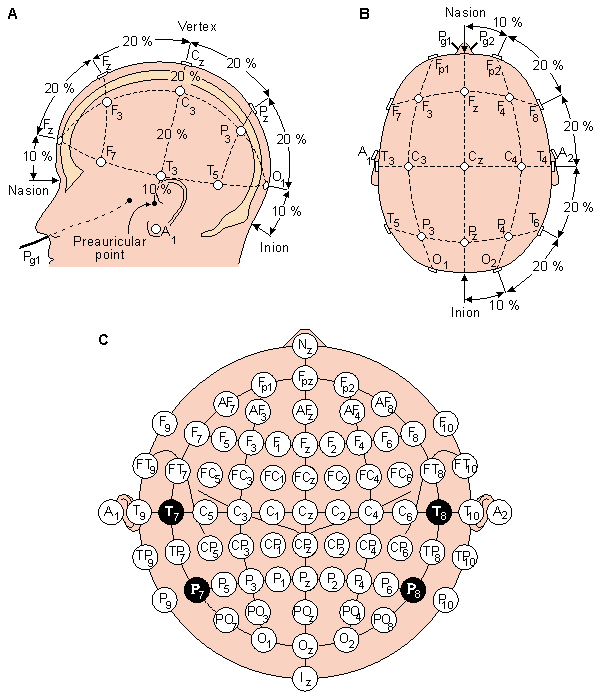

## **Load Data**

In [2]:
path = '../Data'

# Collect all .mat file names
file_names = [
    join(dirname, filename)
    for dirname, _, filenames in os.walk(path)
    for filename in filenames
    if filename.endswith('.mat')
]
        
# Sort files by numerical order (to ensure the correct subject sequence)
file_names.sort(key=lambda x: int(x.split('eeg_record')[-1].split('.mat')[0]))

In [3]:
# Sampling frequency of EEG data
sampFreq = 128
# Names of the channels to be analyzed
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Function to read data
def load_data(file_name):
    mat = loadmat(file_name)
    # Extract data from the 'o' object
    mdata = mat['o']
    data = mdata['data'][0, 0] # Full data

    '''
    EEG data is typically recorded from multiple channels.
    We extract signals only from channels 4-17 (the main EEG channels) for analysis.
    '''
    eeg_data = data[:, 3:17]

    return data, eeg_data

In [4]:
def subject_mapping(total_subjects):
    subject_map = {}
    for subject in range(1, total_subjects + 1):
        start_id = 7 * (subject - 1) + 3
        end_id = start_id + (5 if subject != total_subjects else 4)  # The last subject has 4 trials
        subject_map[subject] = list(range(start_id, end_id))
    return subject_map


# Consider only the last 5 days for each subject
total_subjects = 5

# Create subject_map
subject_map = subject_mapping(total_subjects)
print("Subject mapping:", subject_map)

Subject mapping: {1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}


* **Subject 1:** Participated from day 3 to day 7 (5 actual days).

* **Subject 2:** Participated from day 10 to day 14 (5 actual days).

* **Subject 3:** Participated from day 17 to day 21 (5 actual days).

* **Subject 4:** Participated from day 21 to day 28 (5 actual days)..

* **Subject 5:** Participated from day 31 to day 34 (4 actual days).

In [5]:
def load_eeg_data(file_names):
    all_data = []
    # Create a list of valid trial_id from subject_map
    valid_trial_ids = {trial_id for trial_ids in subject_map.values() for trial_id in trial_ids}
    for file_name in file_names:
        # Extract Trial ID from file name
        trial_id = int(file_name.split('eeg_record')[-1].split('.mat')[0])
        # Check if trail_id is in subject_map
        if trial_id not in valid_trial_ids:
            print(f"Trial ID {trial_id} is not in subject_map, skipping file {file_name}.")
            continue

        try:
            print(f"Processing file: {file_name}, Trial ID: {trial_id}")
            _, eeg_data = load_data(file_name)

            # Check the validity of the returned data
            if eeg_data is not None and eeg_data.size > 0:
                all_data.append((eeg_data))
            else:
                print(f"EEG data from file {file_name} is invalid or empty.")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    
    return all_data

In [6]:
eeg_data = load_eeg_data(file_names)

Trial ID 1 is not in subject_map, skipping file ../Data\eeg_record1.mat.
Trial ID 2 is not in subject_map, skipping file ../Data\eeg_record2.mat.
Processing file: ../Data\eeg_record3.mat, Trial ID: 3
Processing file: ../Data\eeg_record4.mat, Trial ID: 4
Processing file: ../Data\eeg_record5.mat, Trial ID: 5
Processing file: ../Data\eeg_record6.mat, Trial ID: 6
Processing file: ../Data\eeg_record7.mat, Trial ID: 7
Trial ID 8 is not in subject_map, skipping file ../Data\eeg_record8.mat.
Trial ID 9 is not in subject_map, skipping file ../Data\eeg_record9.mat.
Processing file: ../Data\eeg_record10.mat, Trial ID: 10
Processing file: ../Data\eeg_record11.mat, Trial ID: 11
Processing file: ../Data\eeg_record12.mat, Trial ID: 12
Processing file: ../Data\eeg_record13.mat, Trial ID: 13
Processing file: ../Data\eeg_record14.mat, Trial ID: 14
Trial ID 15 is not in subject_map, skipping file ../Data\eeg_record15.mat.
Trial ID 16 is not in subject_map, skipping file ../Data\eeg_record16.mat.
Processi

# **Data Preprocessing**

## **Filter Data**

EEG signals has multiple frequency components, and not all of them are revelant to the brain activities we aim to analyze.

In [7]:
# Function to create a bandpass filter (high-pass and low-pass)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Function to create a notch filter
def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

- The **bandpass filter**: helps eliminate low-frequency noise (e.g., signal drift caused by eye movements, muscle activities or measurement device interference) and high-frequency noise (e.g., interference from mobile phones, computer systems, etc.) This filter allows EEG signals to retain only important frequency components, reducing noise and improving analysis quality.

- The **notch filter**: is used to remove **50Hz** (or 60Hz, depending on the goegraphic region) interference. This type of noise is typically caused by power lines (e.g., household or hospital electrical systems) and can introduce unwanted oscillation in the EEG signal.

In [8]:
def filter_data(data_set):
    # Apply bandpass and notch filtering for each file
    filtered_all_data = []
    for data_eeg in data_set:
        # Appy bandpass and notch filtering to the current file's data
        lowcut = 0.5  # Hz
        highcut = 30  # Hz
        filtered_data_bandpass = bandpass_filter(data_eeg, lowcut, highcut, sampFreq)

        # Apply notch filtering to remove 50Hz noise from the bandpass-filtered data
        notch_freq = 50  # Hz
        filtered_data_notch = notch_filter(filtered_data_bandpass, notch_freq, sampFreq)

        # Store the filtered data in the list
        filtered_all_data.append(filtered_data_notch)
    
    return filtered_all_data

In [9]:
filtered_data = filter_data(eeg_data)

In [10]:
def plot_all_channels(eeg_data_list, channel_names, title="EEG Signals for All Channels",time_range=(5000, 15000)):
    num_channels = len(channel_names)
    start, end = time_range

    # Set up figure size
    fig, axes = plt.subplots(num_channels, 1, figsize=(20, 5 * num_channels))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes):
        # Combine and average data cross channels
        combined_data = np.hstack([eeg_data[start:end, i] for eeg_data in eeg_data_list])
        normalized_data = combined_data - np.mean(combined_data)

        # Plot signal for each channel
        ax.plot(normalized_data)
        ax.set_title(channel_names[i])
        ax.set_ylim(-100,100)
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")

    plt.tight_layout()  
    plt.show()


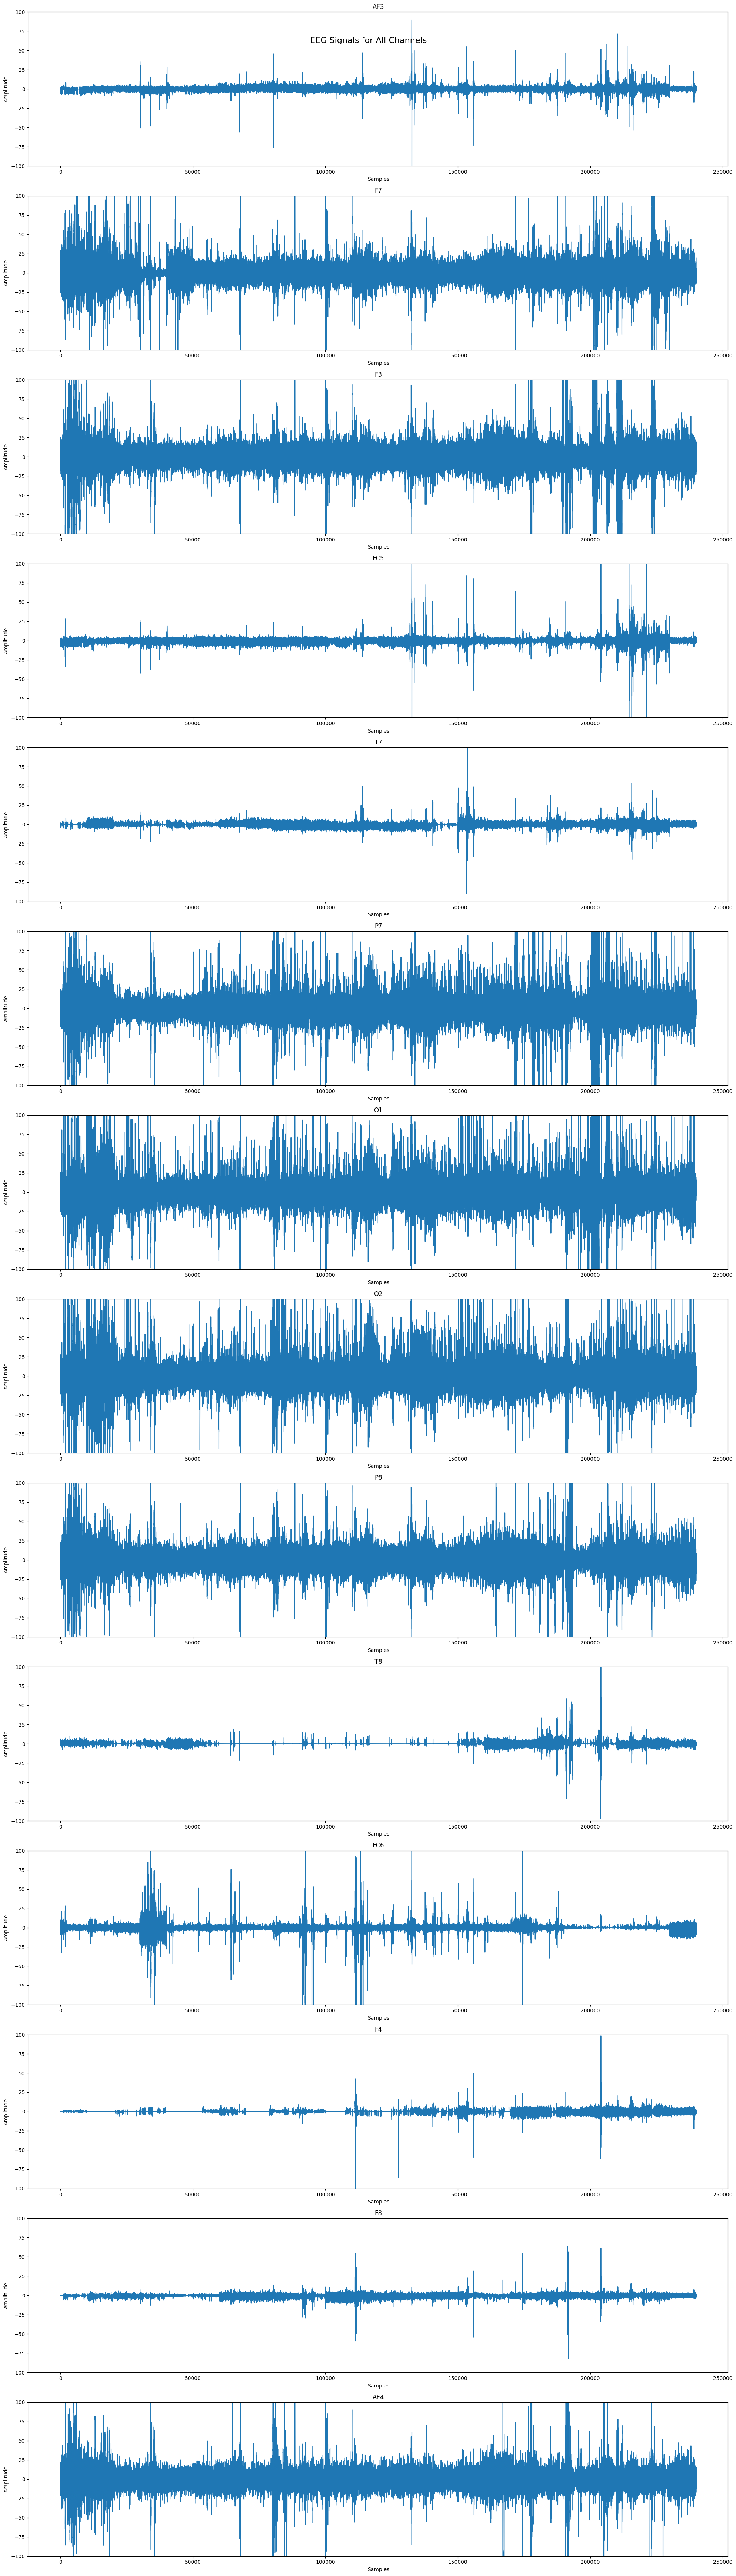

In [11]:
plot_all_channels(filtered_data, channel_names)

To identify the appropriate EEG channels, the `plot_all_channel` function is used to visualize signal data from all channels over a specific time period.

- Based on the visualized plots, select channel with strong and clear oscillations while discarding those with weak or indistinct signals.

- The selected useful channels include: `F7`, `F3`, `P7`, `O1`, `O2`, `P8`, and `AF4`. These channels exhibit significant EEG amplitude variations during the observed period and are suitable for analysis.

In [12]:
useful_channel_idx = [1, 2, 5, 6, 7, 8, 13]
useful_channel_names = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']

# Adjust to use only the 7 selected channels
filtered_data = [eeg_data[:, useful_channel_idx] for eeg_data in filtered_data]

**Visualize after filtering noise**

In [13]:
def plot_signal(filtered_data, file_names, num_files=2):
    # Retrieve trial IDs from subject_map
    trial_ids = [trial_id for ids in subject_map.values() for trial_id in ids]

    # Get the list of valid files
    valid_file_names = [file_names[trial_id - 1] for trial_id in trial_ids]

    # Iterate through the files to visualize
    for idx, file_name in enumerate(valid_file_names[:num_files]):
        filtered_signal = filtered_data[idx]  # Get corresponding filtered data

        # Load raw data
        data, eeg_data = load_data(file_name)

        # Plot full data from the file
        print('Full data from file {}:'.format(file_name), data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(data)
        plt.title(f'Full Data from {file_name}')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Plot EEG data from channels 4-17
        print('\nEEG Data from Channels 4-17:', eeg_data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(eeg_data[:1000, :])  # Assuming plotting the first 1000 samples
        plt.title('EEG Data (Channels 4-17) from 1000 Samples')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Plot filtered EEG signal for the first 1000 samples
        print('\nEEG Data After Noise Filtering:', filtered_signal.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(filtered_signal[:1000, :])  # First 1000 samples from filtered data
        plt.title('EEG Data After Filtering (High-pass, Low-pass, Notch) from 1000 Samples')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

Full data from file ../Data\eeg_record3.mat: (357224, 25)


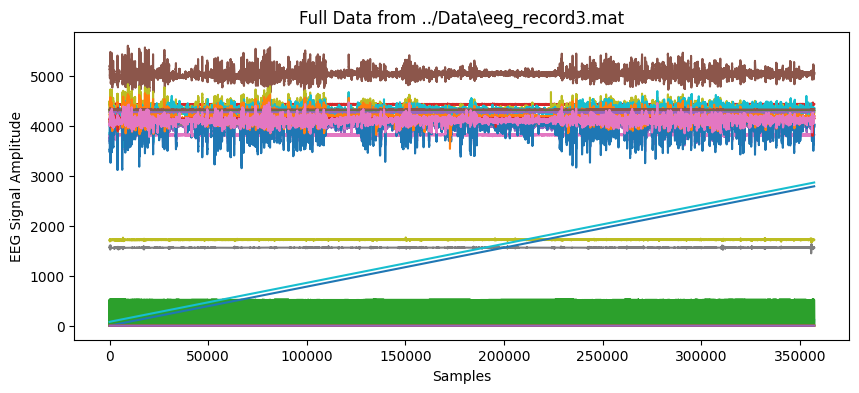


EEG Data from Channels 4-17: (357224, 14)


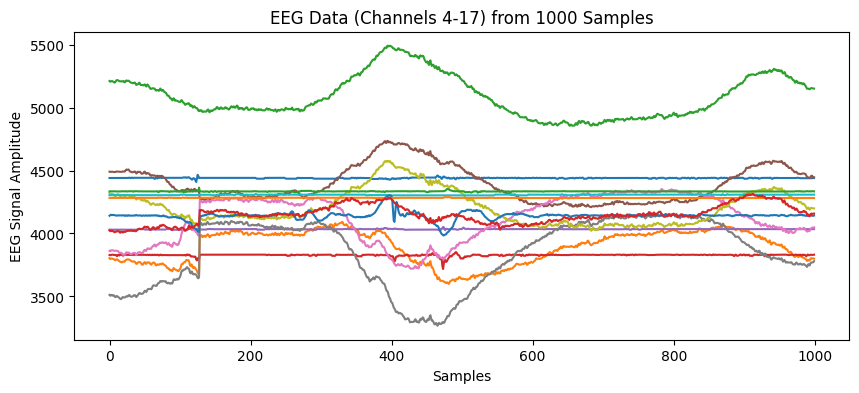


EEG Data After Noise Filtering: (357224, 7)


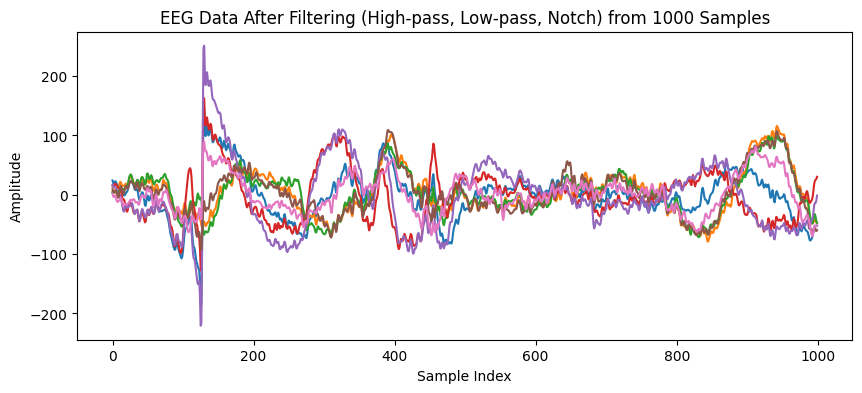

Full data from file ../Data\eeg_record4.mat: (380344, 25)


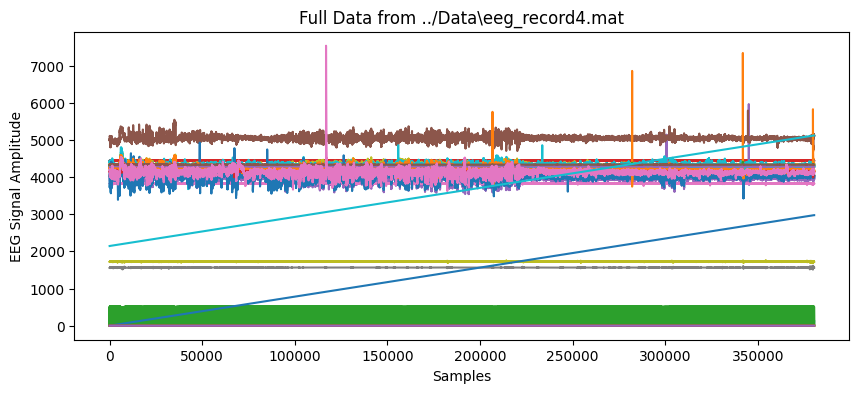


EEG Data from Channels 4-17: (380344, 14)


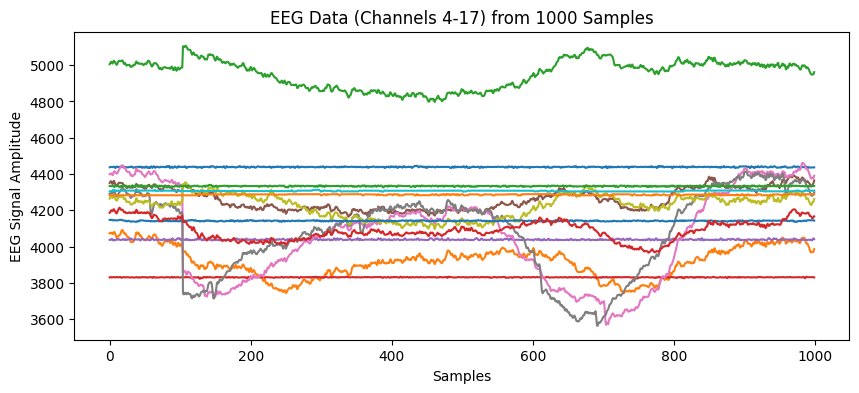


EEG Data After Noise Filtering: (380344, 7)


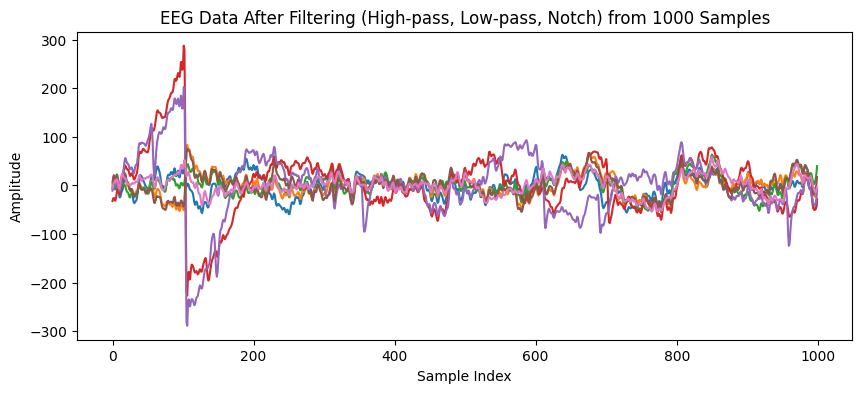

In [14]:
plot_signal(filtered_data, file_names)

### **Visualization Observations**

- Images **1** and **4** depict the complete EEG data from `record 3` and `record 4`, respectively. The x-axis represents the sample index, while the y-axis shows the EEG signal amplitude. Observing the raw data helps indentify noise, signal loss, or general EEG signal characteristics.

- Images **2** and **5** visualize EEG data extracted from `channels 4-17`, which are crucial for analyzing attention states. Displaying data from multiple channels allow for comparisions of signal characteristics, such as amplitude variations or differences in signal patterns. This is particularly useful for understanding the relationships between different EEG channels.

- Images **3** and **6** show EEG signals after applying high-pass, low-pass, and notch filters. These filters help eliminate unwanted noise, especially frequencies outside the region of interest. After filtering, the signals become smoother, making feature extraction and classification more effective and improving accuracy.

Apply bandpass filters (`bandpass_filter function`) to isolate specific frequency bands (`Delta`, `Theta`, `Alpha`, and `Beta`) and visualize them over the first 1000 samples.

- **Delta** band (0.5-4 Hz) is associated with deep sleep.

- **Theta** band (4-8 Hz) is linked to relaxtion.

- **Alpha** band (8-13 Hz) corresponds to a relaxed but alert state.

- **Beta** band (13-30) is associated with focus and stress.

In [15]:
def plot_frequency_bands(filtered_data):
    # Define frequency bands
    delta_low, delta_high = 0.5, 4  # Hz
    theta_low, theta_high = 4, 8  # Hz
    alpha_low, alpha_high = 8, 13  # Hz
    beta_low, beta_high = 13, 30  # Hz

    # Apply bandpass filters to extract different frequency bands
    delta_band = bandpass_filter(filtered_data, delta_low, delta_high, sampFreq)
    theta_band = bandpass_filter(filtered_data, theta_low, theta_high, sampFreq)
    alpha_band = bandpass_filter(filtered_data, alpha_low, alpha_high, sampFreq)
    beta_band = bandpass_filter(filtered_data, beta_low, beta_high, sampFreq)

    # Plot Delta band signal
    plt.figure(figsize=(15, 6))
    plt.plot(delta_band[:1000])  # Display first 1000 samples for better visualization
    plt.title('EEG Delta Band (0.5-4 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Plot Theta band signal
    plt.figure(figsize=(15, 6))
    plt.plot(theta_band[:1000])  # Display first 1000 samples for better visualization
    plt.title('EEG Theta Band (4-8 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Plot Alpha band signal
    plt.figure(figsize=(15, 6))
    plt.plot(alpha_band[:1000])  # Display first 1000 samples for better visualization
    plt.title('EEG Alpha Band (8-13 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Plot Beta band signal
    plt.figure(figsize=(15, 6))
    plt.plot(beta_band[:1000])  # Display first 1000 samples for better visualization
    plt.title('EEG Beta Band (13-30 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()
    

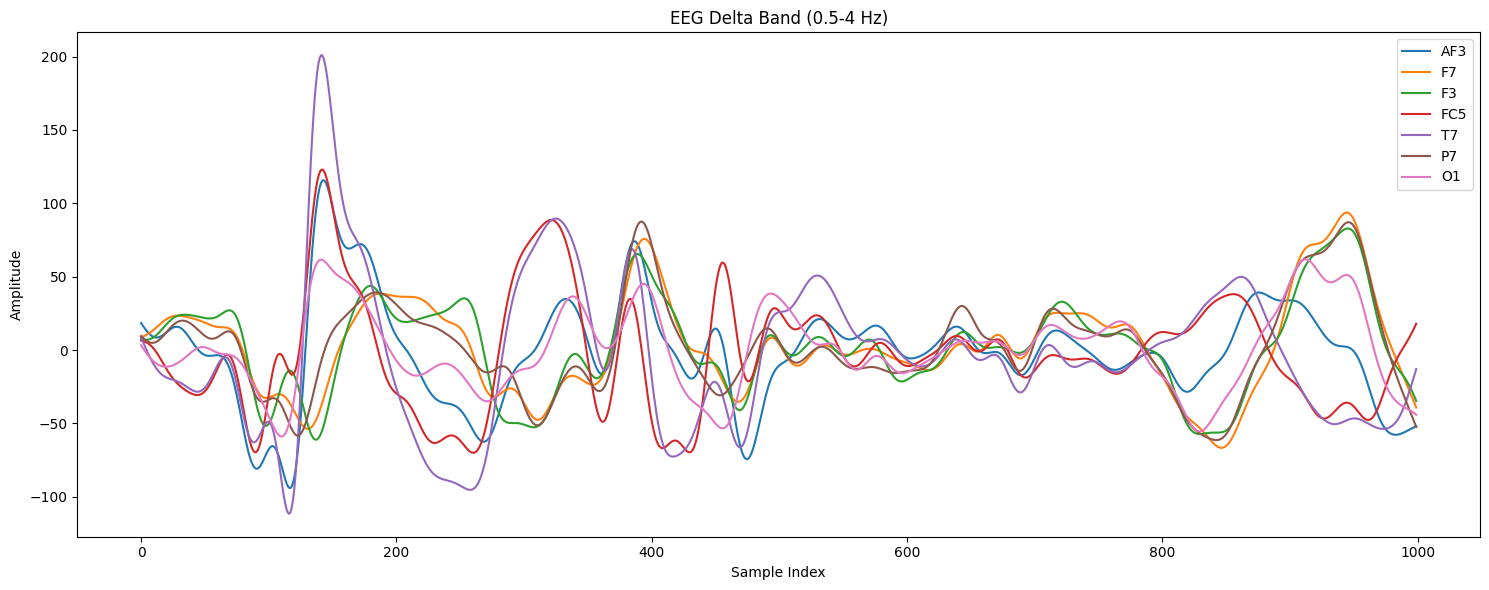

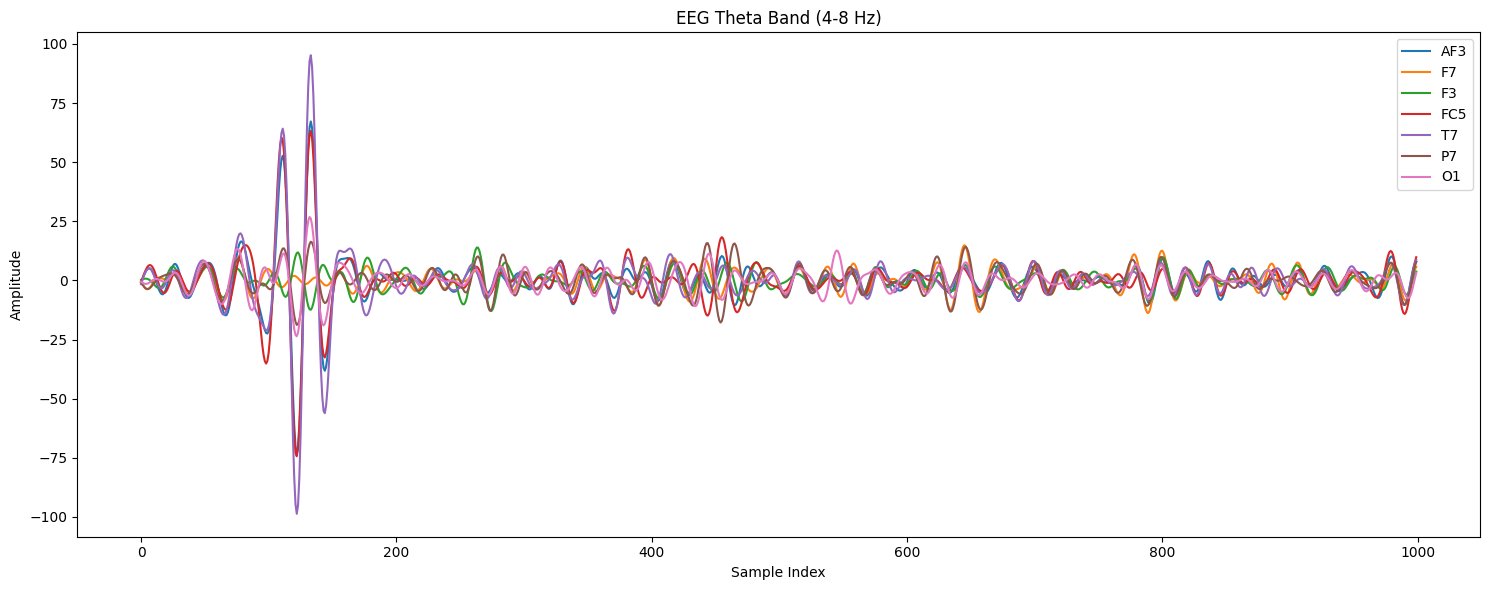

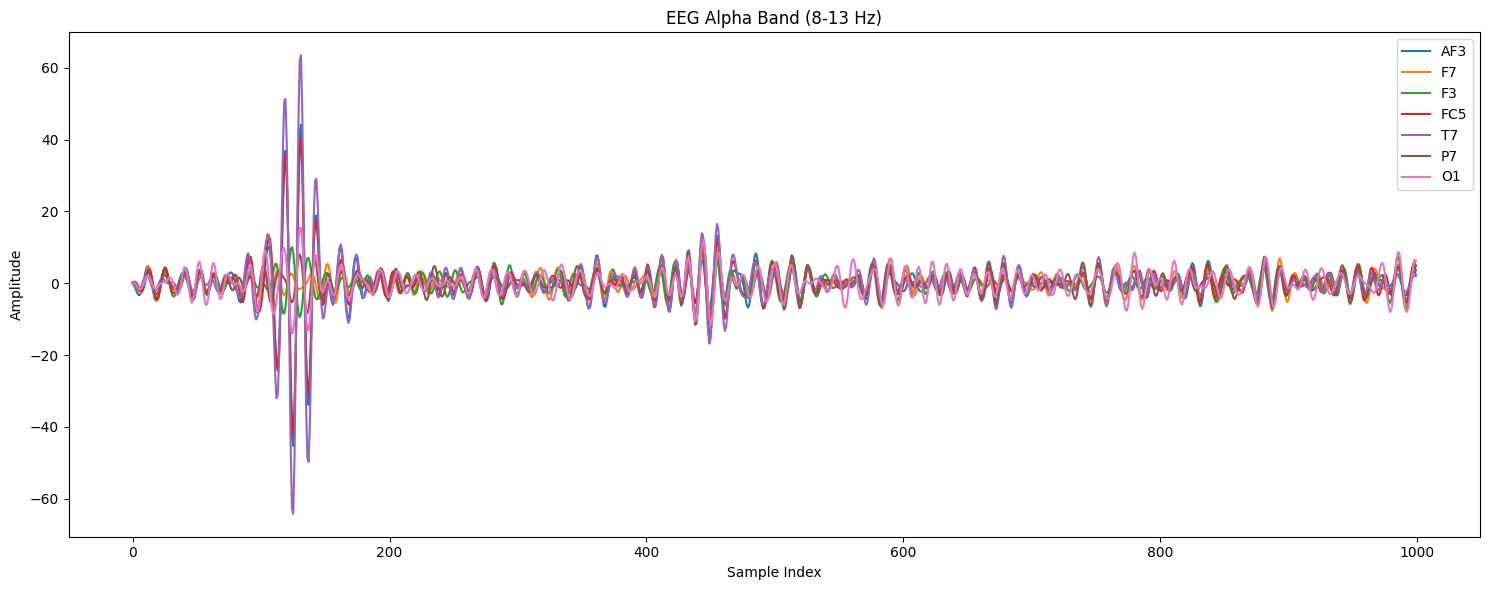

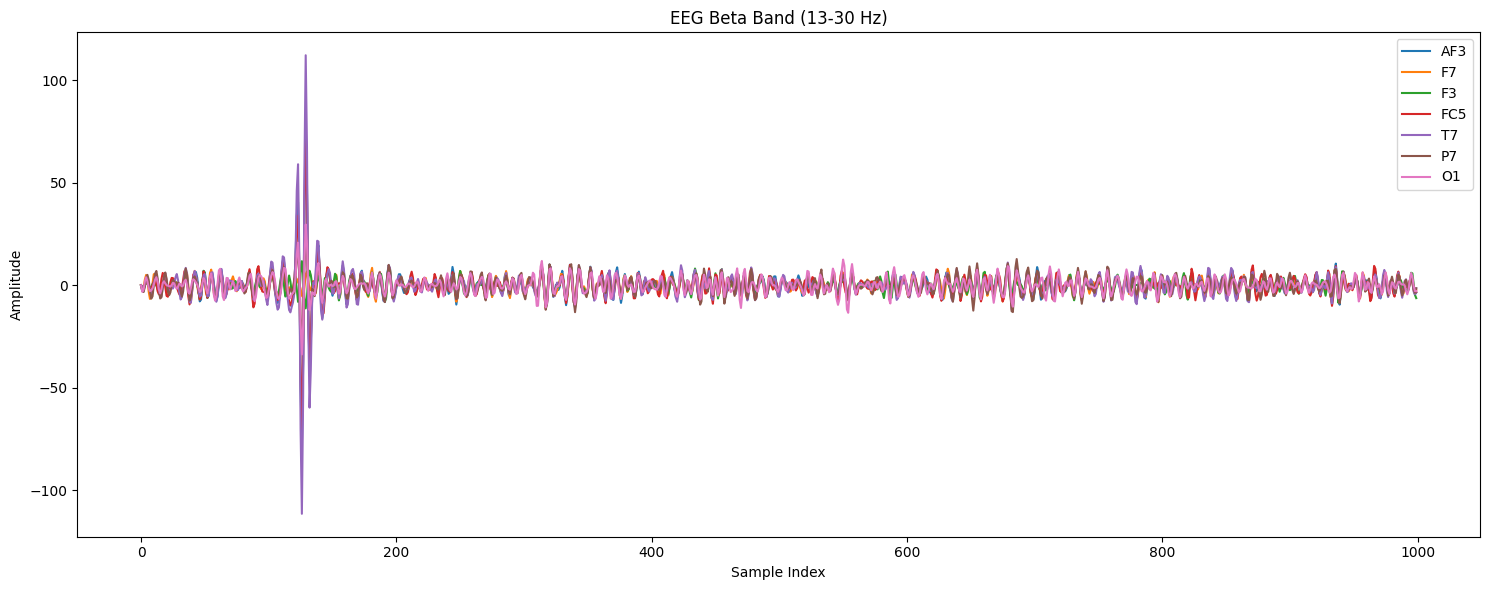

In [16]:
# Visualize first file (file3)
plot_frequency_bands(filtered_data[0])

## **Independent Component Analysis (ICA)**

ICA is a powerful method for separating independent signal components from mixed data. In the context of EEG, recorded signals often consist of a combination of multiple sources, including mechanical noise (such as eye movement artifacts-**EOG**), electrocardiogram (**ECG**) noise, and brain signals. ICA helps to separate these components, allowing the removal of irrelevant noise while preserving components related to brain activity.

In [17]:
def apply_ica(filtered_data):
    ica_list = []
    raw_list = []

    for i in range(len(filtered_data)):

        data_one_day = filtered_data[i]

        '''
        Create information for the Raw object

        mne.create_info: function to create basic information about EEG signals, including:
        - channel names (channel_names)
        - sampling frequency (sfreq)
        - data type (ch_types='eeg').

        '''

        info = mne.create_info(ch_names=useful_channel_names, sfreq=sampFreq, ch_types='eeg')

        # Retrieve the filtered data from the list and convert it to a suitable format for MNE
        filtered_data_mne = data_one_day.T  # Convert to (n_channels, n_times)

        # Create a Raw object from the data
        raw = mne.io.RawArray(filtered_data_mne, info)

        # Add montage to the Raw object using the 'standard_1020' montage
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # Apply ICA to separate independent components
        ica = ICA(n_components=7, random_state=42, max_iter='auto')
        ica.fit(raw)

        # Store ICA and Raw for later use
        ica_list.append(ica)
        raw_list.append(raw)

        # Print notification that processing is complete
        print(f'ICA has been applied to file {i+1}')

    return ica_list, raw_list

In [18]:
# Apply ICA for filtered_data
ica_data, raw_data = apply_ica(filtered_data)

Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 2.6s.
ICA has been applied to file 1
Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 2.1s.
ICA has been applied to file 2
Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.5s.
ICA has been applied to file 3
Creating RawArray with float64 data, n_channels=7, n_times=288752
    Range : 0 ... 288751 =      0.000 ...  2255.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.4s.
ICA has been applied to file 4
Creating RawArray with float64 data, n_channels=7, n_times=398816
    Range : 0 ... 398815 =      0.000 ...  3115.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.0s.
ICA has been applied to file 5
Creating RawArray with float64 data, n_channels=7, n_times=381340
    Range : 0 ... 381339 =      0.000 ...  2979.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.9s.
ICA has been applied to file 6
Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
ICA has been applied to file 7
Creating RawArray with float64 data, n_channels=7, n_times=356728
    Range : 0 ... 356727 =      0.000 ...  2786.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
ICA has been applied to file 8
Creating RawArray with float64 data, n_channels=7, n_times=373304
    Range : 0 ... 373303 =      0.000 ...  2916.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
ICA has been applied to file 9
Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
ICA has been applied to file 10
Creating RawArray with float64 data, n_channels=7, n_times=443972
    Range : 0 ... 443971 =      0.000 ...  3468.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
ICA has been applied to file 11
Creating RawArray with float64 data, n_channels=7, n_times=361840
    Range : 0 ... 361839 =      0.000 ...  2826.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.9s.
ICA has been applied to file 12
Creating RawArray with float64 data, n_channels=7, n_times=333236
    Range : 0 ... 333235 =      0.000 ...  2603.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
ICA has been applied to file 13
Creating RawArray with float64 data, n_channels=7, n_times=396812
    Range : 0 ... 396811 =      0.000 ...  3100.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.2s.
ICA has been applied to file 14
Creating RawArray with float64 data, n_channels=7, n_times=336280
    Range : 0 ... 336279 =      0.000 ...  2627.180 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.8s.
ICA has been applied to file 15
Creating RawArray with float64 data, n_channels=7, n_times=360928
    Range : 0 ... 360927 =      0.000 ...  2819.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
ICA has been applied to file 16
Creating RawArray with float64 data, n_channels=7, n_times=415164
    Range : 0 ... 415163 =      0.000 ...  3243.461 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
ICA has been applied to file 17
Creating RawArray with float64 data, n_channels=7, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.4s.
ICA has been applied to file 18
Creating RawArray with float64 data, n_channels=7, n_times=347548
    Range : 0 ... 347547 =      0.000 ...  2715.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.0s.
ICA has been applied to file 19
Creating RawArray with float64 data, n_channels=7, n_times=214540
    Range : 0 ... 214539 =      0.000 ...  1676.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.9s.
ICA has been applied to file 20
Creating RawArray with float64 data, n_channels=7, n_times=428848
    Range : 0 ... 428847 =      0.000 ...  3350.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.4s.
ICA has been applied to file 21
Creating RawArray with float64 data, n_channels=7, n_times=483732
    Range : 0 ... 483731 =      0.000 ...  3779.148 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 1.9s.
ICA has been applied to file 22
Creating RawArray with float64 data, n_channels=7, n_times=483376
    Range : 0 ... 483375 =      0.000 ...  3776.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 6.9s.
ICA has been applied to file 23
Creating RawArray with float64 data, n_channels=7, n_times=408976
    Range : 0 ... 408975 =      0.000 ...  3195.117 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_12336\3507771957.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 6.9s.
ICA has been applied to file 24


`plot_ica_components` function is used to visualize the ICA components (computed from ICA objects applied to EEG data) for a certain number of files and display the signal of these components when applied to the raw data.

In [19]:
def plot_ica_components(ica_list, raw_list, num_files=2, start_index=2, step=7):
    """
        ica_list: A list of ICA objects that have been computed for each EEG data file.
                  Each object in this list contains ICA components (independent sources) extracted from the data.
        raw_list: A list of Raw objects (raw EEG data) corresponding to the files in ica_list.
                  Each Raw object contains EEG data collected from a subject at a specific time.

        start_index (int): The starting index of the file. Default is 2 (starting from the 3rd file).
        step (int): The step size between files. Default is 7.
    """
    # Compute the indices of the files to be plotted
    indices_to_plot = [start_index + i * step for i in range(num_files)]

    for idx in indices_to_plot:
        if idx >= len(ica_list):  # Case where the index is invalid
            print(f'File index {idx + 1} exceeds the number of files in the list.')
            continue  
        # Case where the index is valid
        print(f'Plotting ICA components for file {idx + 1}')

        # Plot ICA components
        ica_list[idx].plot_components()

        # Plot ICA component signals with Raw data
        ica_list[idx].plot_sources(raw_list[idx], start=0, stop=40, show_scrollbars=False)

        plt.show()


**Topomap visualization of ICA components extracted from EEG data (individual visualization per subject). Each ICA components is represented on a map, illustrating its spatial distribution on the scalp.**

- Each circle in the plot represents an independent component (ICA000, ICA001,..., ICA013), reflecting the decomposition of EEG signals into separate sources. The ICA technique helps distinguish different signal sources, such as brain activity and artifacts from eye or muscle movements.

- Colors in the topomap:

    - Red and blue indicate positive and negative signal amplitudes. Red areas represent signal enhancement, while blue areas show amplitude reduction.

    - Contour lines on the map depict intensity variations, helping to visualize the spatial distribution of signals across the scalp.

- Spatial distribution of ICA components:

    - The topomap describes how each ICA component is distributed on the scalp, aiding in identifying whether a component corresponds to a specific type of artifact (e.g., eye movement, muscle noise)

For example:

- A component with strong intensity in the frontal region may be associated with eye movements or blinking.

- Other components may represent muscle artifacts or genuine brain signals.

This analysis not only helps identify noise in EEG signals but also provides clearer insights into brain activity during data collection.

Plotting ICA components for file 3


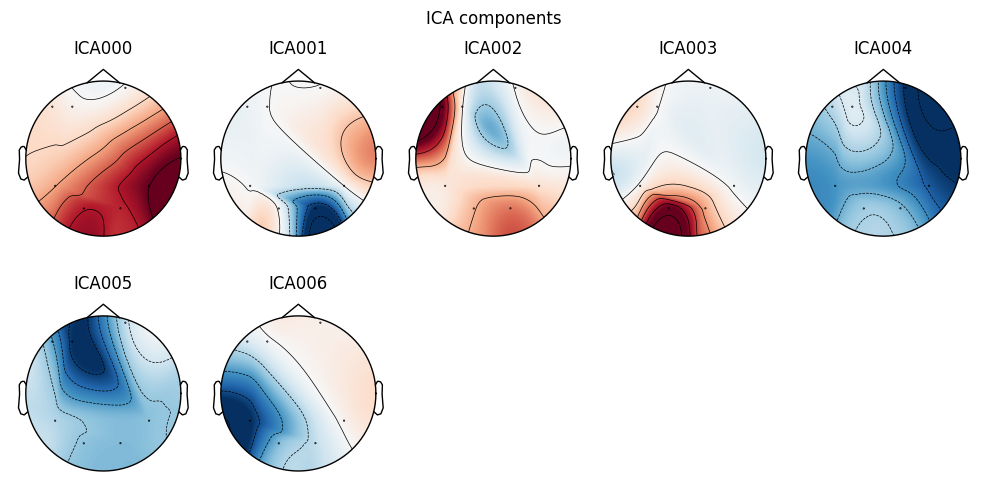

Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Using matplotlib as 2D backend.


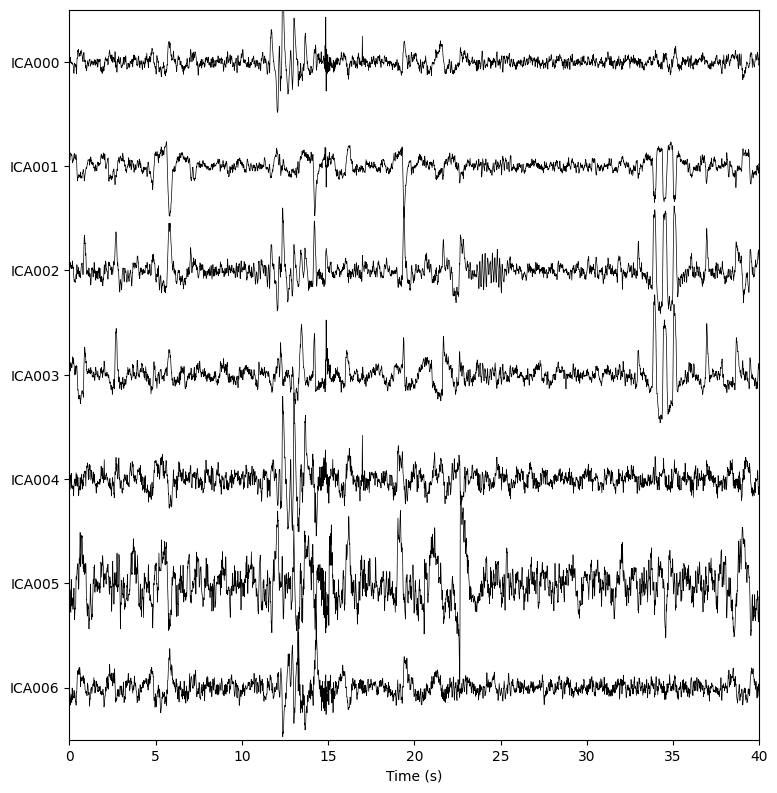

Plotting ICA components for file 10


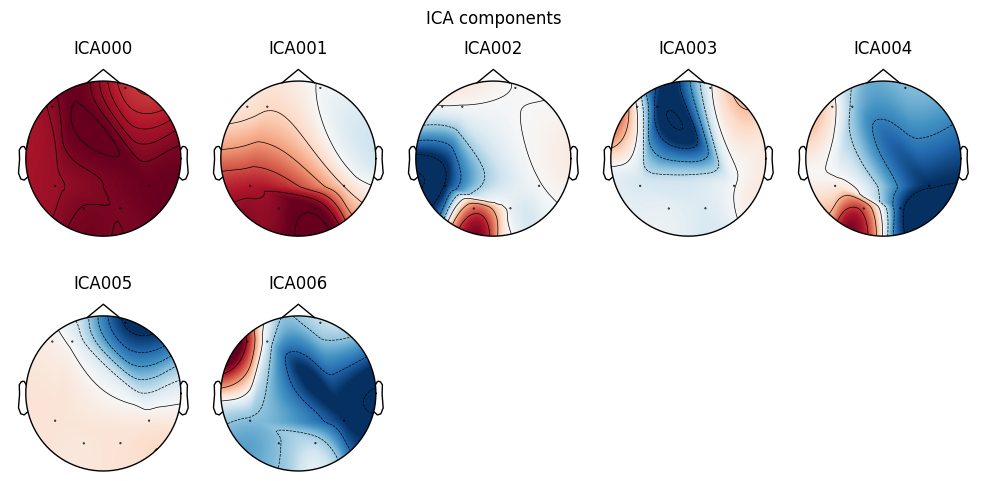

Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.


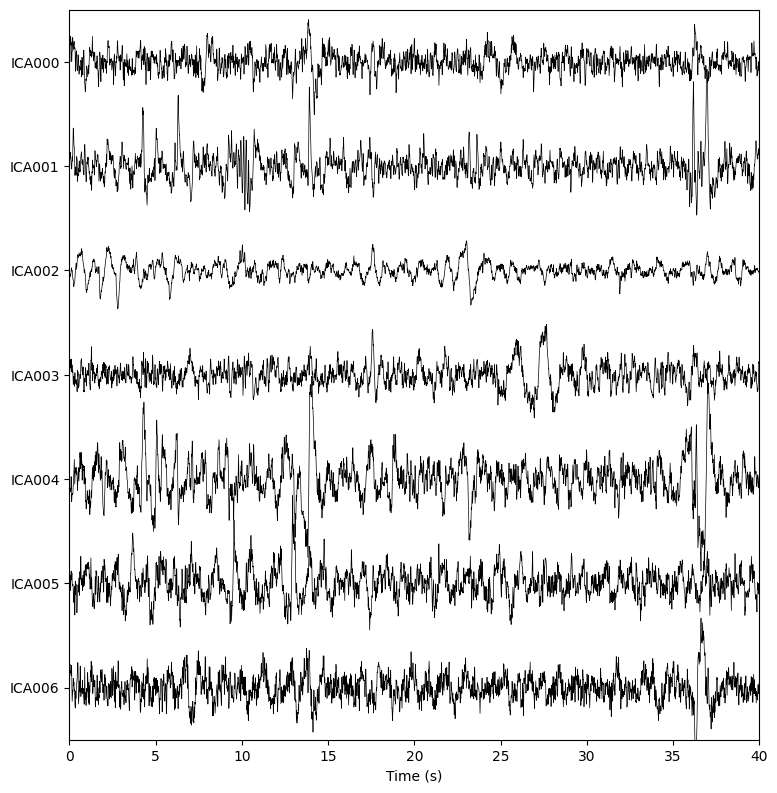

In [20]:
plot_ica_components(ica_data, raw_data)

**Detection of EOG and ECG Artifact**

- **EOG artifacts**: EOG signals arise from eye movements (e.g., blinking or shifting gaze), generating small electrical currents detectable on the skin near the eyes. These signals can interfere with EEG recordings, making brainwave analysis more challenging.

- **ECG artifacts**: EEG artifacts occur when cardiac signals (including electrical waves generated by heart activity) infiltrate EEG channels. These artifacts can distort brain signals and need to be detected and removed.

In [21]:
def detect_eog_artifacts(ica, raw, eye_channels):
    # Store indices of ICA components causing EOG artifacts for each eye channel
    all_eog_indices = {}

    for ch in eye_channels:
        if ch in raw.ch_names:  # Check if the channel exists in the Raw object
            try:
                # Detect blink (EOG) artifacts
                eog_indices, _ = ica.find_bads_eog(raw, ch_name=ch)
                all_eog_indices[ch] = eog_indices
                # print(f"ICA components related to eye blinks in channel {ch}: {eog_indices}")
            except Exception as e:
                print(f"Error processing channel {ch}: {e}")

    return all_eog_indices

def detect_ecg_artifacts(ica, raw, heart_related_channels):
    all_ecg_indices = {}

    for ch in heart_related_channels:
        if ch in raw.ch_names:  # Check if the channel exists in the Raw object
            try:
                # Detect heartbeat (ECG) artifacts
                ecg_indices, _ = ica.find_bads_ecg(raw, ch_name=ch)
                all_ecg_indices[ch] = ecg_indices
                # print(f"ICA components related to heartbeat in channel {ch}: {ecg_indices}")
            except Exception as e:
                print(f"Error processing channel {ch}: {e}")

    return all_ecg_indices

def print_indices_results(all_eog_indices, all_ecg_indices):
    # Print EOG results
    print("\nResults from all EOG channels:")
    for ch, indices in all_eog_indices.items():
        print(f"Channel {ch}: ICA components {indices}")

    # Print ECG results
    print("\nResults from all ECG channels:")
    for ch, indices in all_ecg_indices.items():
        print(f"Channel {ch}: ICA components {indices}")


During EEG signal processing, external noise sources such as eye movement (EOG) and cardiac activity (ECG) can distort brain signals and make it difficult to analyze brain wave characteristics. To enhance EEG signals, apply the ICA method to detect and remove these artifacts. The channels selected for detecting eye- and heart-related noise were identified based on their physiological characteristics.

The commonly used channels related to eye movement include:

- `AF4`: A channel near the frontal region that can capture signals from eye movements.

- `F7`: A channel near the temporal region, where voltage changes caused by eye movements can be recorded.

- `F3`: A channel near the frontal cortex, which can also capture signals from eye movements.

These channels were chosen because they are located near areas directly by eye movement, allowing for more effective detection and removal of EOG artifacts.

The selected channels showed no significant interference from cardiac activity when examining EEG channels. The retained EEG channels include `F7`, `F3`, `P7`, `O1`, `O2`, `P8`, and `AF4`—channels that are minimally affected by ECG signals. This helps ensure the accuracy of the analysis, focusing on brain signals and improving reliability in assessing mental attention states.

In [22]:
def detect_artifacts(ica_list, raw_list):
    # List of channels affected by eye and heart-related noise
    eye_channels = ['AF4', 'F7', 'F3']
    heart_channels = []
    
    # Initialize lists to store ICA component indices for EOG and ECG artifacts
    eog_indices = []
    ecg_indices = []

    # Iterate through each file in raw_list and ica_list
    for i in range(len(raw_list)):  # Each Raw object in raw_list corresponds to an ICA object in ica_list
        print(f"\nResults for file #{i + 1}:")

        # Detect EOG and ECG artifacts for each file
        eog = detect_eog_artifacts(ica_list[i], raw_list[i], eye_channels)
        ecg = detect_ecg_artifacts(ica_list[i], raw_list[i], heart_channels)

        eog_indices.append(eog)
        ecg_indices.append(ecg)

    return eog_indices, ecg_indices

In [23]:
eog_indices, ecg_indices = detect_artifacts(ica_data, raw_data)


Results for file #1:
Using EOG channel: AF4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff f

In [24]:
def get_artifacts_table(eog_indices, ecg_indices, data_type="EOG"):
    # Data structure to store ICA artifact indices for each channel
    artifact_data = {channel: [] for channel in useful_channel_names}

    # Iterate through each file to extract ICA artifact indices
    for artifact in (eog_indices if data_type == "EOG" else ecg_indices):
        for channel in useful_channel_names:
            # Retrieve ICA components associated with artifacts for this channel
            artifact_data[channel].append(artifact.get(channel, []))

    # Convert to DataFrame
    artifact_df = pd.DataFrame(artifact_data)

    # Return results as a transposed DataFrame (each file as a column)
    return artifact_df.transpose()

# Print EOG results
eog_full_df = get_artifacts_table(eog_indices, ecg_indices, data_type="EOG")
print("ICA component indices affected by eye movement artifacts (EOG) - Full Data:")
print(eog_full_df)

# Print ECG results
ecg_full_df = get_artifacts_table(eog_indices, ecg_indices, data_type="ECG")
print("\nICA component indices affected by heart activity artifacts (ECG) - Full Data:")
print(ecg_full_df)

ICA component indices affected by eye movement artifacts (EOG) - Full Data:
     0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  19  20  \
F7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
F3   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O1   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O2   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P8   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
AF4  []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   

     21  22  23  
F7   []  []  []  
F3   []  []  []  
P7   []  []  []  
O1   []  []  []  
O2   []  []  []  
P8   []  []  []  
AF4  []  []  []  

[7 rows x 24 columns]

ICA component indices affected by heart activity artifacts (ECG) - Full Data:
     0   1   2   3   4   5   6   7   

After applying the ICA method to detect EOG and ECG in EEG channels, the results are as follows:

- `EOG Artifacts`: No ICA components were identified as EOG artifacts in the selected EEG channels (F7, F3, P7, O1, O2, P8, AF4). This indicates that these channels are minimally affected by eye movements, ensuring cleaner signals and more accurate brainwave analysis.

- `ECG Artifacts`: The EEG channels also did not exhibit significant ECG artifacts, maintaining stable signal quality without interference from cardiac activity.

Next, using the `exclude_ica_components` function to remove unwanted ICA components.

- This function takes in a list of ICA and Raw objects, as well as the ICA component indices identified as artifacts due to EOG and ECG.

- After aggregating the ICA component indices affected by eye and cardiac signals, the function excludes these components from further analysis.

However, in this case, no ICA components were identified as EOG or ECG artifacts.

In [25]:
def exclude_ica_components(ica_list, raw_list, eog_indices_list, ecg_indices_list):
    excluded_raw_list = []
    excluded_ica_list = []

    for idx, (ica, raw, eog_indices, ecg_indices) in enumerate(zip(ica_list, raw_list, eog_indices_list, ecg_indices_list)):
        print(f"\nRemoving ICA components for file #{idx + 1}:")

        # Aggregate ICA components identified as artifacts
        exclude_indices = set()
        for eog in eog_indices.values():
            exclude_indices.update(eog)
        for ecg in ecg_indices.values():
            exclude_indices.update(ecg)

        # Update the exclusion list in ICA
        ica.exclude = list(exclude_indices)
        print(f"Excluded ICA components: {ica.exclude}")

        # Create a copy of the Raw object to apply exclusion without modifying original data
        raw_copy = raw.copy()
        ica.apply(raw_copy)

        # Store the cleaned data
        excluded_raw_list.append(raw_copy)
        excluded_ica_list.append(ica) 
        print(f"Successfully removed artifacts for file #{idx + 1}")
    
    return excluded_raw_list, excluded_ica_list


excluded_raw, excluded_ica = exclude_ica_components(ica_data, raw_data, eog_indices, ecg_indices)


Removing ICA components for file #1:
Excluded ICA components: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Successfully removed artifacts for file #1

Removing ICA components for file #2:
Excluded ICA components: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Successfully removed artifacts for file #2

Removing ICA components for file #3:
Excluded ICA components: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Successfully removed artifacts for file #3

Removing ICA components for file #4:
Excluded ICA components: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Success

In [26]:
# Store data in a dictionary with keys as 'file_1', 'file_2', ...
data_ICA = {}

for idx, raw in enumerate(excluded_raw):
    file_key = f"file_{idx + 1}"   # Key for each file (file_1, file_2, ...)
    data_ICA[file_key] = raw.get_data().T   # Store the file's data in the dictionary

In [27]:
# Print sample data for one person (5 files)
data_ICA['file_1']

array([[24.19749715,  6.000844  ,  4.23830329, ..., 16.96838106,
        10.22124606,  1.91832993],
       [19.72127985,  2.85110049,  3.29300664, ..., 14.33737549,
         5.4407345 , -3.05514881],
       [19.0679392 ,  3.3923298 ,  3.41850959, ..., 12.97791356,
         3.86129927, -3.880416  ],
       ...,
       [12.42305188, 18.81125479,  7.11168582, ..., 13.9125882 ,
        12.92372268,  6.00828526],
       [ 8.8658258 , 14.07675821,  6.68788509, ..., 11.32867891,
        10.06841613,  4.72079507],
       [ 2.85255593,  5.58936839,  2.62482199, ...,  1.51582002,
         5.10406494,  3.4232087 ]])

In [28]:
# Print data for 1 person (5 file)
data_ICA['file_1'].shape

(357224, 7)

## **Label**

- Label the states (**Focused**, **Unfocused**, **Drowsy**) for the data.

- At this stage, our team organizes the data for each subject and state. The result is a dictionary containing data for each attention state, which supports the analysis and model building process.

In [29]:
def restructure_data(data_ICA, fs=128):
    # Create a dictionary to store the data
    data_dict = {'Focused': {}, 'Unfocused': {}, 'Drowsy': {}}

    # Define the number of samples per time period
    samples_per_minute = fs * 60
    samples_10_minutes = samples_per_minute * 10
    samples_20_minutes = samples_per_minute * 20  # This variable is not used in the code, can be removed

    # Split the data for each subject and state
    for file_key, data in data_ICA.items():
        # Split the data into 3 parts: focused, unfocused, drowsy
        focus_data = data[:samples_10_minutes, :]
        unfocus_data = data[samples_10_minutes:samples_20_minutes, :]
        drowsy_data = data[samples_20_minutes:, :]

        # Store the data for each state
        if 'file' in file_key:
            data_dict['Focused'][file_key] = focus_data
            data_dict['Unfocused'][file_key] = unfocus_data
            data_dict['Drowsy'][file_key] = drowsy_data

    return data_dict

In [30]:
data_dict = restructure_data(data_ICA)
data_dict

{'Focused': {'file_1': array([[ 24.19749715,   6.000844  ,   4.23830329, ...,  16.96838106,
           10.22124606,   1.91832993],
         [ 19.72127985,   2.85110049,   3.29300664, ...,  14.33737549,
            5.4407345 ,  -3.05514881],
         [ 19.0679392 ,   3.3923298 ,   3.41850959, ...,  12.97791356,
            3.86129927,  -3.880416  ],
         ...,
         [ -0.28155099,  50.20058714,  53.85385125, ..., -25.804     ,
           45.52720325,   9.87031701],
         [ -8.61901116,  40.09076436,  46.10443682, ..., -29.73870852,
           36.01721502,   0.30084403],
         [-20.52610441,  27.52399184,  36.18596241, ..., -36.41044807,
           23.14074918,  -8.4927055 ]]),
  'file_2': array([[ -6.75091581,   0.97402038,  -4.83068237, ..., -10.81059783,
            6.20316657,  -5.9723539 ],
         [ -2.54908266,   9.80281058,   3.92012574, ...,  -5.83730209,
           17.65620756,   2.08026862],
         [ -2.23339941,  12.19591815,   4.22821803, ...,  -2.70794101,
  

In [31]:
# Lưu dữ liệu dưới dạng file pickle
def save_data_as_pickle(data_dict, filename="Data_After_Processing.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)

# Lưu data_dict dưới dạng file pickle
save_data_as_pickle(data_dict)